In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('data_model/loan_data.csv')

In [6]:
#Check dataset is loaded
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [7]:
# Missing values check
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Gender               5
Dependents           8
Self_Employed       21
Loan_Amount_Term    11
Credit_History      30
dtype: int64

In [263]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


In [8]:
# Fill missing values 
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['LoanAmount']= df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term']= df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())
# Missing values check fill
missing_values

Gender               5
Dependents           8
Self_Employed       21
Loan_Amount_Term    11
Credit_History      30
dtype: int64

In [9]:
# replace 3+ dependents 
df['Dependents'] = df['Dependents'].replace('3+', '5').astype(int)

In [10]:
# Categorical and numerical dataset features:
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['Dependents', 'ApplicantIncome','CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

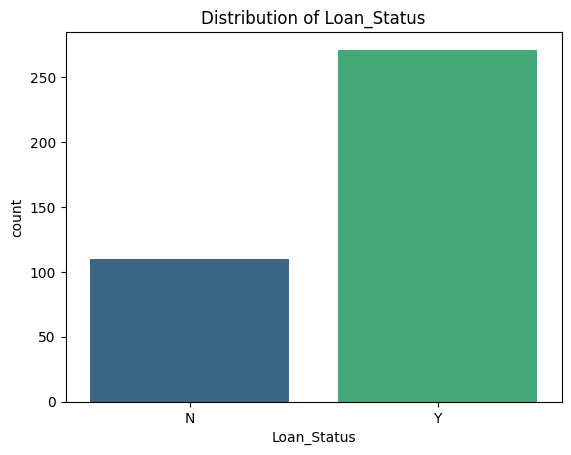

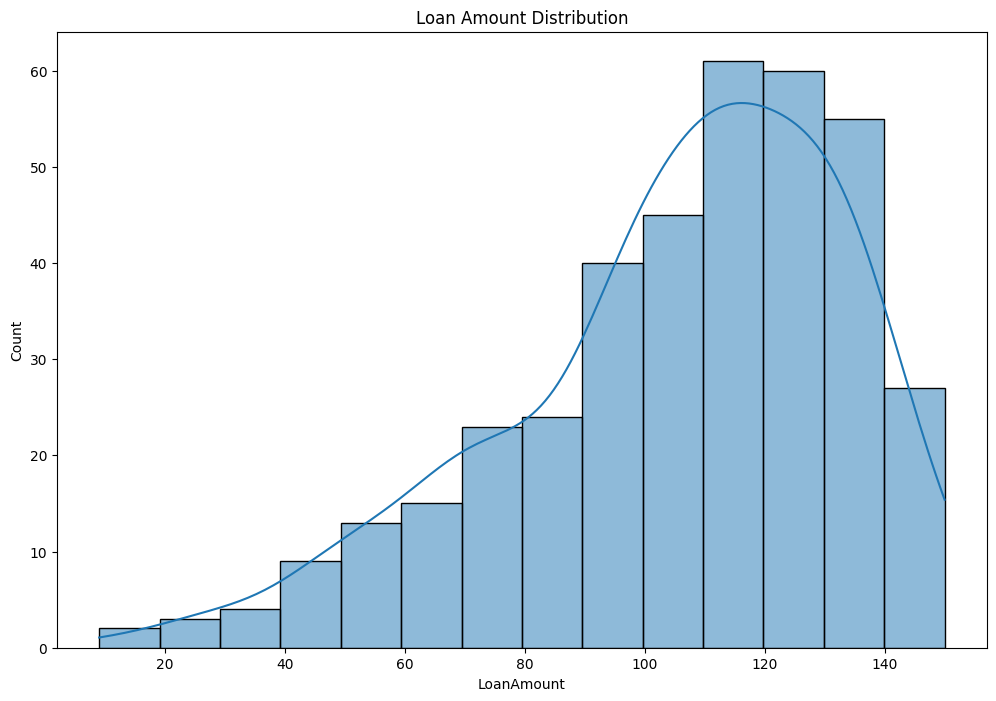

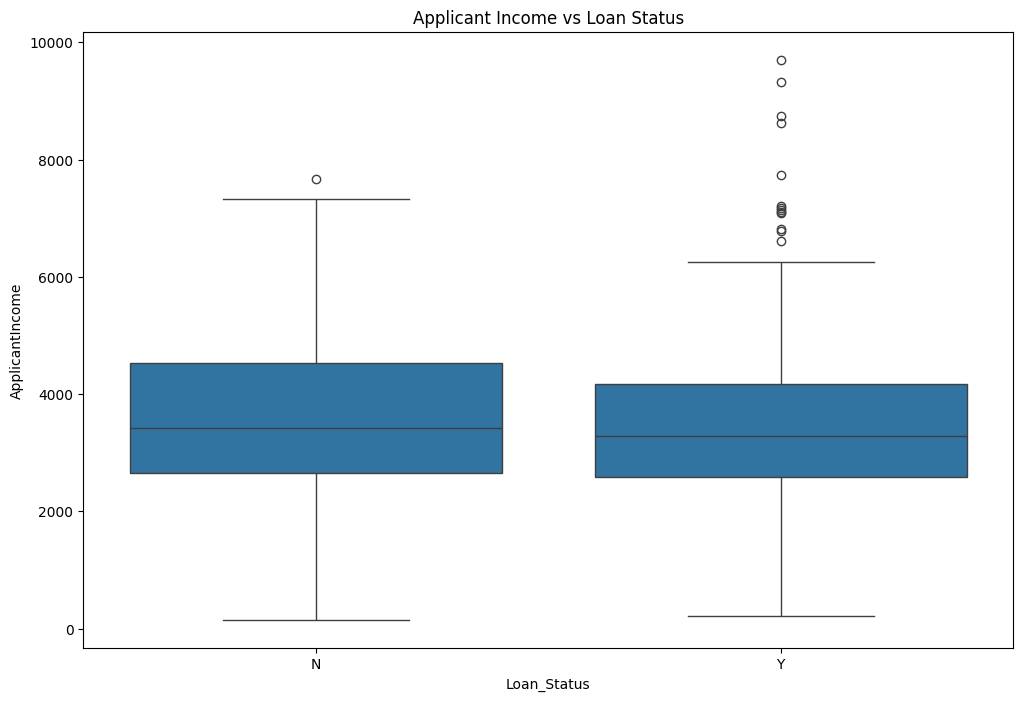

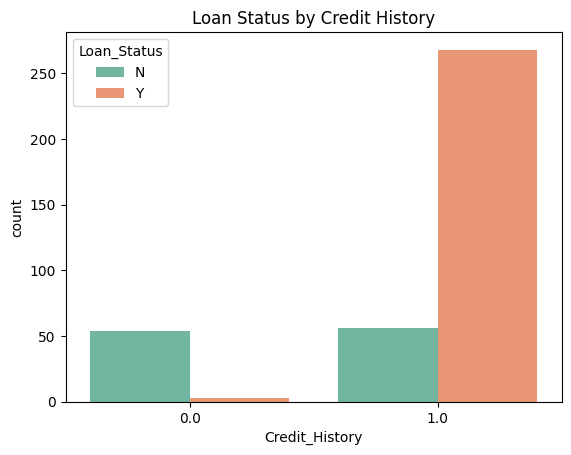

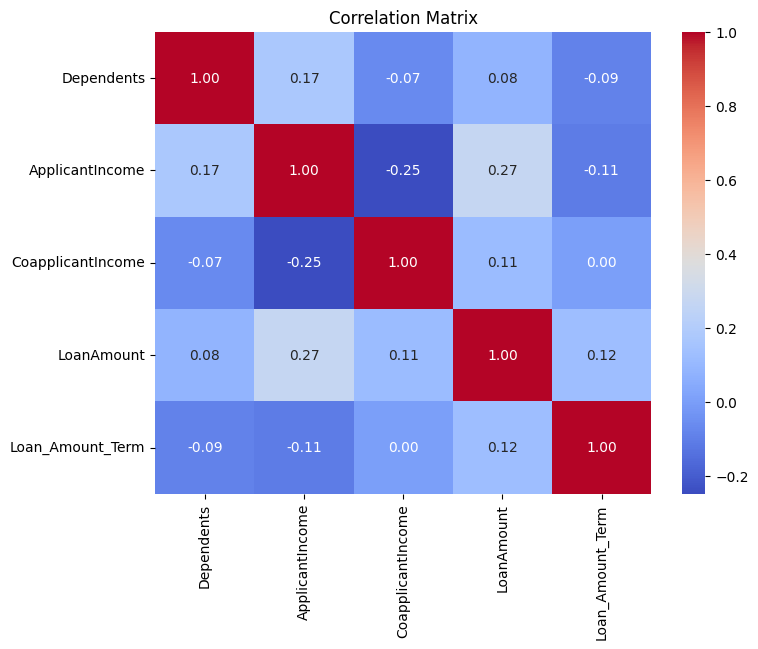

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# Distribution of Loan_Status
sns.countplot(x='Loan_Status', hue='Loan_Status', data=df, palette='viridis')
plt.title('Distribution of Loan_Status')
plt.show()

# Distribution of Loan amount 
plt.figure(figsize=(12, 8))
sns.histplot(df['LoanAmount'], kde=True)
plt.title('Loan Amount Distribution')
plt.show()

# Analyzizng relationship between Applicant income and Loan status.
plt.figure(figsize=(12, 8))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df)
plt.title('Applicant Income vs Loan Status')
plt.show()

# Analyzizng relationship between Credit history and Loan status
sns.countplot(x='Credit_History', hue='Loan_Status', data=df, palette='Set2')
plt.title('Loan Status by Credit History')
plt.show()

# Analyze correlation for numerical variables
correlation_matrix = df[numerical_features].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Features and target variable:
X = df.drop(columns=['Loan_Status']).drop(columns=['Loan_ID'])
y = df['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Train and test data split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and pipeline creation:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]
)

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_params

{'classifier__max_depth': 20,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200}

In [13]:
# Evaluating model on test dataset
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7012987012987013
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.14      0.21        21
           1       0.74      0.91      0.82        56

    accuracy                           0.70        77
   macro avg       0.56      0.53      0.51        77
weighted avg       0.64      0.70      0.65        77



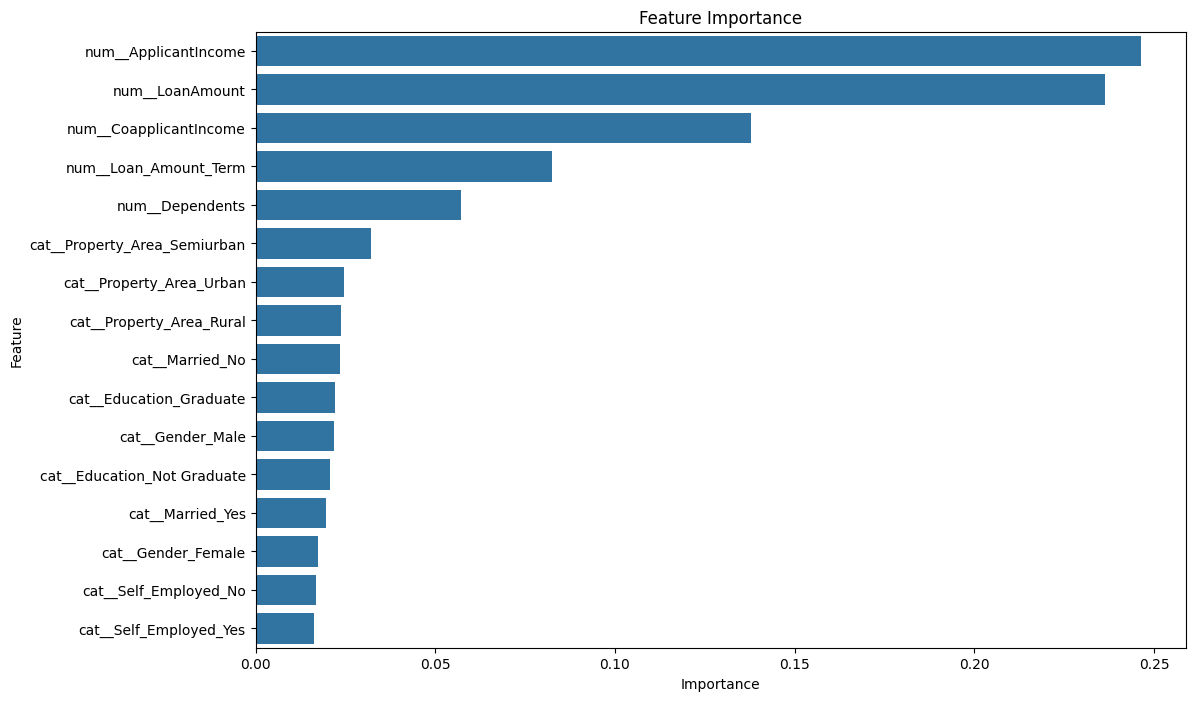

In [14]:
# Feature importance plot
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = grid_search.best_estimator_.named_steps["preprocessor"].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()